# Detecting urban area with radar <img align="right" src="https://raw.githubusercontent.com/GeoscienceAustralia/dea-notebooks/develop/Supplementary_data/dea_logo.jpg">

* **[Sign up to the DEA Sandbox](https://app.sandbox.dea.ga.gov.au/)** to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment only
* **Products used:** 
[ga_s1_rtc_backscatter_experimental](https://explorer.dev.dea.ga.gov.au/products/ga_s1_rtc_backscatter_experimental)

## Description

Testing the development of a ML-based urban classifier by combining Sentinel-1 with Landsat geomedians.  Notebook first create a simple threshold based classifier to see how effective this is, then proceeds to create the ML version for comparison.

### Load packages
Load key Python packages and supporting functions for the analysis.

In [ ]:
# !pip install shap
# !pip install lightgbm

In [1]:
%matplotlib inline

import datacube
import numpy as np
import xarray as xr 
import pandas as pd
import geopandas as gpd
from odc.geo.xr import assign_crs
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.plotting import display_map
from dea_tools.dask import create_local_dask_cluster
from dea_tools.bandindices import calculate_indices

In [2]:
client = create_local_dask_cluster(return_client=True)

### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [3]:
dc = datacube.Datacube(app='S1_Backscatter')

In [4]:
dc_products = dc.list_products()
dc_products.loc[["ga_s1_iw_vv_vh_c0", "ga_s1_iw_vv_c0", "ga_s1_iw_hh_c0"]]

name  \
name                                   
ga_s1_iw_vv_vh_c0  ga_s1_iw_vv_vh_c0   
ga_s1_iw_vv_c0        ga_s1_iw_vv_c0   
ga_s1_iw_hh_c0        ga_s1_iw_hh_c0   

                                                         description  \
name                                                                   
ga_s1_iw_vv_vh_c0  Geoscience Australia Sentinel-1 Interferometri...   
ga_s1_iw_vv_c0     Geoscience Australia Sentinel-1 Interferometri...   
ga_s1_iw_hh_c0     Geoscience Australia Sentinel-1 Interferometri...   

                     license default_crs default_resolution  
name                                                         
ga_s1_iw_vv_vh_c0  CC-BY-4.0        None               None  
ga_s1_iw_vv_c0     CC-BY-4.0        None               None  
ga_s1_iw_hh_c0     CC-BY-4.0        None               None

## Analysis parameters

In [5]:
# Set the central latitude and longitude
central_lat = -35.29
central_lon =  149.113

# Set the buffer to load around the central coordinates. 
buffer = 0.2

# Compute the bounding box for the study area
latitude = (central_lat - buffer, central_lat + buffer)
longitude = (central_lon - buffer, central_lon + buffer)

start_date = "2024-01-01"
end_date = "2024-12-31"

### View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [6]:
# display_map(x=longitude, y=latitude)

## Load and view Sentinel-1 data

The first step in the analysis is to load Sentinel-1 backscatter data for the specified area of interest.

In [7]:
# Lazy load our filtered data
ds_s1 = dc.load(
    product="ga_s1_iw_vv_vh_c0",
    x=longitude,
    y=latitude,
    time=(start_date, end_date),
    measurements=["VV", "VH", "mask"],
    group_by="solar_day",
    output_crs="EPSG:3577",
    resolution=(20, -20),
    dask_chunks={'x':1024,'y':1024}
)

ds_s1

<xarray.Dataset> Size: 3GB
Dimensions:      (time: 58, y: 2447, x: 2097)
Coordinates:
  * time         (time) datetime64[ns] 464B 2024-01-08T19:16:40.408056 ... 20...
  * y            (y) float64 20kB -3.983e+06 -3.983e+06 ... -3.934e+06
  * x            (x) float64 17kB 1.57e+06 1.57e+06 ... 1.528e+06 1.528e+06
    spatial_ref  int32 4B 3577
Data variables:
    VV           (time, y, x) float32 1GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    VH           (time, y, x) float32 1GB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    mask         (time, y, x) uint8 298MB dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Apply the mask

In [8]:
valid_mask = xr.where(ds_s1.mask>0, False, True)
ds_s1 = ds_s1.where(valid_mask).drop_vars('mask')

In [9]:
# t=-2
# fig, ax = plt.subplots(1,3, figsize=(15, 4), sharey=True)

# ds_s1['VV'].isel(time=t).plot(ax=ax[0], robust=True)
# ds_s1['VH'].isel(time=t).plot(ax=ax[1], robust=True)
# ds_s1['mask'].isel(time=t).plot(ax=ax[2],levels=[-0.5, 0.5, 1.5, 2.5, 3.5], 
#     cbar_kwargs={'ticks': [0, 1, 2, 3]});

# ax[0].set_title()

### Visualise loaded data

After conversion to dB

In [10]:
def dB_scale(data): 
    '''Scales a xarray.DataArray with linear DN to a dB scale.'''
    # Explicitly set negative data to nan to avoid log of negative number
    negative_free_data = data.where(data >= 0, np.nan)
    return 10 * np.log10(negative_free_data)

# Scale to plot data in decibels
ds_s1["VH"] = dB_scale(ds_s1.VH)
# Scale to plot data in decibels
ds_s1["VV"] = dB_scale(ds_s1.VV)


# Plot the average of all VV observations
mean_vv_dB = ds_s1.VV.mean(dim="time").compute()
# std_vv_dB = ds_s1.vv_dB.std(dim="time")

fig,ax = plt.subplots(1,1,figsize=(6, 6), sharey=True)
mean_vv_dB.plot(cmap="Greys_r", robust=True, ax=ax)
plt.title("Average VV");

## Preprocessing the data through filtering

### Speckle Filtering using Lee Filter

In [12]:
# # Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python
# from scipy.ndimage import uniform_filter

# def lee_filter(img, size):
#     """
#     Applies the Lee filter to reduce speckle noise in an image.

#     Parameters:
#     img (ndarray): Input image to be filtered.
#     size (int): Size of the uniform filter window.

#     Returns:
#     ndarray: The filtered image.
#     """
#     img_mean = uniform_filter(img, size)
#     img_sqr_mean = uniform_filter(img**2, size)
#     img_variance = img_sqr_mean - img_mean**2

#     overall_variance = np.var(img)

#     img_weights = img_variance / (img_variance + overall_variance)
#     img_output = img_mean + img_weights * (img - img_mean)
#     return img_output

# # Define a function to apply the Lee filter to a DataArray
# def apply_lee_filter(data_array, size=7):
#     """
#     Applies the Lee filter to the provided DataArray.

#     Parameters:
#     data_array (xarray.DataArray): The data array to be filtered.
#     size (int): Size of the uniform filter window. Default is 7.

#     Returns:
#     xarray.DataArray: The filtered data array.
#     """
#     data_array_filled = data_array.fillna(0)
#     filtered_data = xr.apply_ufunc(
#         lee_filter, data_array_filled,
#         kwargs={"size": size},
#         input_core_dims=[["y", "x"]],
#         output_core_dims=[["y", "x"]],
#         dask_gufunc_kwargs={"allow_rechunk": True},
#         vectorize=True,
#         dask="parallelized",
#         output_dtypes=[data_array.dtype]
#     )
#     return filtered_data

In [13]:
# The lee filter above doesn't handle null values
# We therefore set null values to 0 before applying the filter
# valid_inf = np.isfinite(ds_s1)

# ds_s1 = ds_s1.where(valid, 0)

# ds_s1["vh_dB_filtered"] = apply_lee_filter(ds_s1.vh_dB, size = 4)
# ds_s1["vv_dB_filtered"] = apply_lee_filter(ds_s1.vv_dB, size = 4)

# ds_s1["vh_dB_filtered"] = ds_s1["vh_dB_filtered"].where(valid_mask)
# ds_s1["vv_dB_filtered"] = ds_s1["vv_dB_filtered"].where(valid_mask)


## Designing a threshold-based urban classifier

In [14]:
from skimage.filters import threshold_otsu
x = ds_s1.vv_dB_filtered.data.compute()
x = x[~np.isnan(x)] 

threshold_vv = threshold_otsu(x)

print(threshold_vv)

mean_vv_dB = ds_s1.vv_dB_filtered.mean(dim="time").compute()

### Plot

In [15]:
#add geomedian
gm = dc.load(product='ga_ls8cls9c_gm_cyear_3',
             like=ds_s1, # will match S1
             time=(start_date, end_date),
             resampling='bilinear'
            ).squeeze().drop_vars('time')

gm = gm.drop_vars('count')
gm = calculate_indices(gm, index='NDVI', collection='ga_ls_3' )

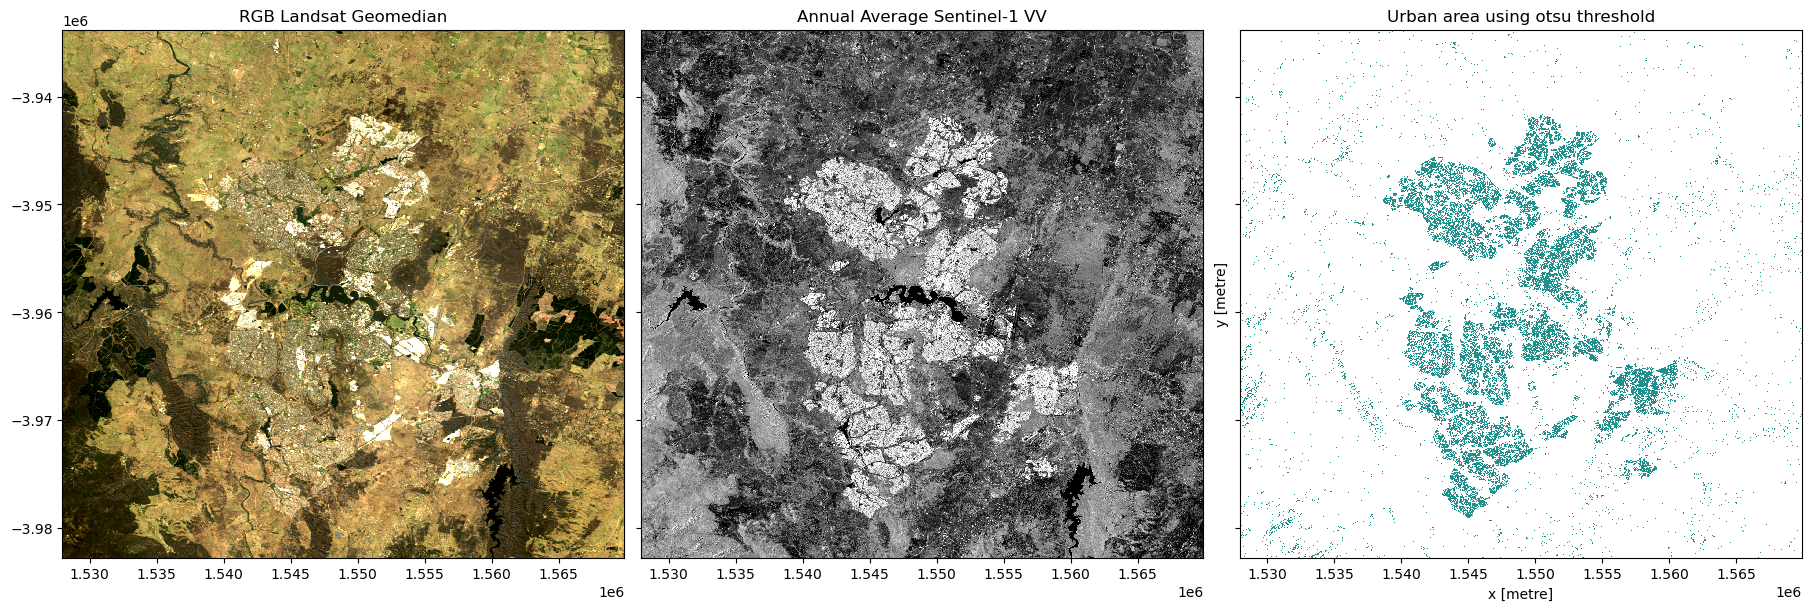

In [16]:
fig,ax = plt.subplots(1,3,figsize=(18, 6), sharey=True, layout='constrained')

gm[['nbart_red', 'nbart_green', 'nbart_blue']].to_array().plot.imshow(robust=True, ax=ax[0], add_labels=False)
ax[0].set_title("RGB Landsat Geomedian");

mean_vv_dB.plot(cmap="Greys_r", robust=True, ax=ax[1], add_labels=False, add_colorbar=False)
ax[1].set_title("Annual Average Sentinel-1 VV");

urban = (mean_vv_dB > -8.5)
urban.where(urban>0).plot.imshow(ax=ax[2], add_colorbar=False)
ax[2].set_title('Urban area using otsu threshold');

## ML based classifier

use the GUF layer to create training points

In [17]:
from random_sampling import random_sampling
from odc.io.cgroups import get_cpu_quota
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV, ShuffleSplit, KFold, RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, balanced_accuracy_score, f1_score
import pprint

import sys
sys.path.insert(1, '../Tools/')
from dea_tools.classification import collect_training_data

In [18]:
ncpus = round(get_cpu_quota())
start_date = "2024-01-01"
end_date = "2024-12-31"

### Create training points

In [19]:
urban_GUF = xr.open_dataarray('https://thredds.nci.org.au/thredds/dodsC/ub8/au/LandCover/OzWALD_LC/GUF_FractionUrban_Australia.nc')
urban_GUF = urban_GUF.transpose('latitude', 'longitude')
urban_GUF = assign_crs(urban_GUF, crs='EPSG:4326')

urban_GUF = urban_GUF.odc.reproject(how=gm.odc.geobox, resampling='bilinear')
urban = xr.where(urban_GUF>75, 1, urban_GUF)
urban = xr.where((urban <=75) & (urban >1), 2, urban)
urban = assign_crs(urban.astype('int16'), crs='EPSG:3577')


4046


<Axes: >

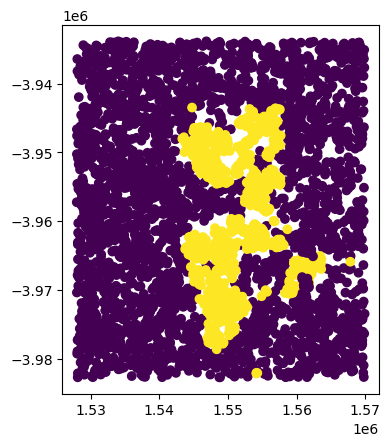

In [22]:
train_points = random_sampling(urban, sampling='manual', manual_class_ratios={'1':1000, '0':3000})
train_points = train_points.drop('spatial_ref', axis=1)
train_points['class'] = train_points['class'].astype(int)

# add manually collected counter examples for false positives
counters = gpd.read_file('counter_examples.geojson')
counters['class'] = 0
counters = counters.to_crs(train_points.crs)
train_points = pd.concat([train_points, counters]).reset_index(drop=True)
print(len(train_points))
train_points.plot(column='class', markersize=1)

### Extract training data

In [25]:
# Generate a new datacube query object
query = {
    'time': (start_date, end_date),
    'resolution': (20, -20),
    'output_crs': "EPSG:3577",
    # 'dask_chunks':{}
    # 'group_by': 'solar_day',
}

In [26]:
def feature_layers(query):
    
    # Connect to the datacube
    dc = datacube.Datacube(app='custom_feature_layers')
    
    ds_s1 = dc.load(
        product="ga_s1_iw_vv_vh_c0",
        measurements=["VV", "VH", "mask"],
        group_by="solar_day",
        **query,
        )

    #mask data
    valid_mask = xr.where(ds_s1.mask>0, False, True)
    ds_s1 = ds_s1.where(valid_mask).drop_vars('mask')

    def dB_scale(data): 
        '''Scales a xarray.DataArray with linear DN to a dB scale.'''
        # Explicitly set negative data to nan to avoid log of negative number
        negative_free_data = data.where(data >= 0, np.nan)
        return 10 * np.log10(negative_free_data)

    # Scale to plot data in decibels
    ds_s1["VH"] = dB_scale(ds_s1.VH)
    ds_s1["VV"] = dB_scale(ds_s1.VV)

    ds_s1 = ds_s1.where(valid_mask)

    #take temporal stats
    ds_s1_mean = ds_s1.mean('time')
    ds_s1_max = ds_s1.max('time')
    ds_s1_min = ds_s1.min('time')
    ds_s1_std = ds_s1.std('time')
    
    ds_s1_mean = ds_s1_mean.rename({'VV':'VV_mean', 'VH':'VH_mean'})
    ds_s1_max = ds_s1_max.rename({'VV':'VV_max', 'VH':'VH_max'})
    ds_s1_min = ds_s1_min.rename({'VV':'VV_min', 'VH':'VH_min'})
    ds_s1_std = ds_s1_std.rename({'VV':'VV_std', 'VH':'VH_std'})

    #add geomedian
    gm = dc.load(product='ga_ls8cls9c_gm_cyear_3',
                 like=ds_s1, # will match S1
                 time=query.get('time'),  # use time if in query
                 resampling='bilinear',
                 # dask_chunks={},
                ).squeeze().drop_vars('time')
    
    gm = gm.drop_vars('count')
    
    # # Calculate some band indices
    gm = calculate_indices(gm,
                           index=['NDVI'],
                           drop=False,
                           collection='ga_ls_3')

    # gm = gm[['bcdev', 'sdev', 'edev']]

    # Merge results into single dataset 
    result = xr.merge([gm, ds_s1_mean, ds_s1_max, ds_s1_min, ds_s1_std], compat='override')
    
    return result

In [27]:
client.shutdown()

In [ ]:
column_names, model_input = collect_training_data(
    gdf=train_points,
    dc_query=query,
    ncpus=ncpus,
    return_coords=False,
    field='class',
    zonal_stats=None,
    feature_func=feature_layers
)

In [29]:
print(column_names)
print('')
print(np.array_str(model_input, precision=3, suppress_small=True))

['class', 'nbart_blue', 'nbart_green', 'nbart_red', 'nbart_nir', 'nbart_swir_1', 'nbart_swir_2', 'sdev', 'edev', 'bcdev', 'NDVI', 'VV_mean', 'VH_mean', 'VV_max', 'VH_max', 'VV_min', 'VH_min', 'VV_std', 'VH_std']

[[  0.    486.    800.    ... -26.424   2.024   2.441]
 [  0.    490.    793.    ... -31.942   1.905   3.799]
 [  0.    298.    408.    ... -22.255   2.358   2.278]
 ...
 [  0.    397.    454.    ... -20.952   2.057   1.933]
 [  0.    345.    466.    ... -21.594   2.142   2.342]
 [  0.    371.    508.    ... -23.349   1.565   2.461]]


In [30]:
# Set the name and location of the output file
output_file = "training_data.txt"
# Export files to disk
np.savetxt(output_file, model_input, header=" ".join(column_names), fmt="%4f")

### Fit and test a model

In [31]:
inner_cv_splits = 3

outer_cv_splits = 3

test_size = 0.20

Classifier = LGBMClassifier

In [32]:
training_data = "training_data.txt"

# load the data
model_input = np.loadtxt(training_data)

# load the column_names
with open(training_data, 'r') as file:
    header = file.readline()
    
column_names = header.split()[1:]

# Extract relevant indices from training data
model_col_indices = [column_names.index(var_name) for var_name in column_names[1:]]

# Convert variable names into sci-kit learn nomenclature
X = model_input[:, model_col_indices]
y = model_input[:, 0]

In [46]:
# Create the parameter grid based on the results of random search
param_grid = {
    'num_leaves': [5, 10,15],  # model complexity
    'max_depth': [1,2,5, 10],  # -1 for no limit, or moderate depth
    # 'learning_rate': [0.05, 0.1],  # small range for quick convergence
    'n_estimators': [100, 200, 300],  # fewer estimators for speed
    'min_child_samples': [10, 20],  # regularization
    'colsample_bytree': [0.8, 1.0],  # feature sampling
    'class_weight': [None, 'balanced'],  # account for imbalance
}


In [47]:
outer_cv = KFold(n_splits=outer_cv_splits, shuffle=True,
                        random_state=0)

# lists to store results of CV testing
acc = []
f1 = []
roc_auc = []
i = 1

for train_index, test_index in outer_cv.split(X, y):
    print(f"Working on {i}/{outer_cv_splits} outer CV split", end='\r')
    model = Classifier(random_state=1, n_jobs=1, verbose=-1)

    # Index training, testing, and coordinate data
    X_tr, X_tt = X[train_index, :], X[test_index, :]
    y_tr, y_tt = y[train_index], y[test_index]
    
    # Inner split on data within outer split
    inner_cv = KFold(n_splits=inner_cv_splits,
                     shuffle=True,
                     random_state=0)
    
    clf = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=50,
        # scoring='f1',
        # n_jobs=-1,
        refit=True,
        verbose=0,
        cv=inner_cv.split(X_tr, y_tr)
    )

    clf.fit(X_tr, y_tr)
    
    # Predict using the best model
    best_model = clf.best_estimator_
    pred = best_model.predict(X_tt)

    # Evaluate model w/ multiple metrics
    # ROC AUC
    probs = best_model.predict_proba(X_tt)
    probs = probs[:, 1]
    fpr, tpr, thresholds = roc_curve(y_tt, probs)
    auc_ = auc(fpr, tpr)
    roc_auc.append(auc_)
    
    # Overall accuracy
    ac = balanced_accuracy_score(y_tt, pred)
    acc.append(ac)
    
    # F1 scores
    f1_ = f1_score(y_tt, pred)
    f1.append(f1_)
    i += 1

In [48]:
print("=== Nested K-Fold Cross-Validation Scores ===")
print("Mean balanced accuracy: "+ str(round(np.mean(acc), 2)))
print("Std balanced accuracy: "+ str(round(np.std(acc), 2)))
print('\n')
print("Mean F1: "+ str(round(np.mean(f1), 2)))
print("Std F1: "+ str(round(np.std(f1), 2)))
print('\n')
print("Mean roc_auc: "+ str(round(np.mean(roc_auc), 3)))
print("Std roc_auc: "+ str(round(np.std(roc_auc), 2)))
print('=============================================')

=== Nested K-Fold Cross-Validation Scores ===
Mean balanced accuracy: 0.63
Std balanced accuracy: 0.01


Mean F1: 0.43
Std F1: 0.01


Mean roc_auc: 0.797
Std roc_auc: 0.02


In [49]:
# Generate n_splits of train-test_split
rs = ShuffleSplit(n_splits=outer_cv_splits, test_size=test_size, random_state=0)

In [50]:
# Instatiate a gridsearchCV
model = Classifier(random_state=1, n_jobs=1, verbose=-1)

clf = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grid,
        n_iter=200,
       # scoring='f1',
       verbose=0,
       cv=rs.split(X, y),
       n_jobs=-1
)

clf.fit(X, y)

print('\n')
print("The most accurate combination of tested parameters is: ")
pprint.pprint(clf.best_params_)
print('\n')
print(f"The score using these parameters is: ")
print(round(clf.best_score_, 2))



The most accurate combination of tested parameters is: 
{'class_weight': None,
 'colsample_bytree': 0.8,
 'max_depth': 5,
 'min_child_samples': 20,
 'n_estimators': 200,
 'num_leaves': 10}


The score using these parameters is: 
0.79


In [51]:
# Create a new model
new_model = Classifier(**clf.best_params_, random_state=1, n_jobs=ncpus)
new_model.fit(X, y)

LGBMClassifier(colsample_bytree=0.8, max_depth=5, n_estimators=200, n_jobs=31,
               num_leaves=10, random_state=1)

In [52]:
from joblib import dump
dump(new_model, 'urban_model.joblib')

['urban_model.joblib']

### Feature importance

Text(0.5, 1.0, 'Feature importance using SHAP')

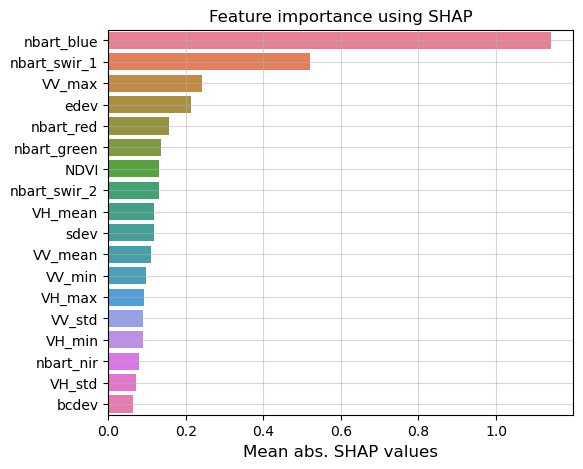

In [82]:
import shap
explainer = shap.TreeExplainer(new_model)
        
shap_values = explainer(X)
vals = np.abs(shap_values.values).mean(0)
df = pd.DataFrame(list(zip(column_names[1:], vals)), columns=['col_name','feature_importance_vals'])
df.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)
df = df.set_index('col_name', drop=True)

fig, ax = plt.subplots(1,1, figsize=(6,5))
sb.barplot(data = df.T, orient='h', ax=ax)
ax.set_xlabel('Mean abs. SHAP values', fontsize=12)
ax.set_ylabel('')
ax.grid(alpha=0.5);
ax.set_title('Feature importance using SHAP');

### Predictions

In [83]:
from dea_tools.classification import predict_xr
from dea_tools.plotting import rgb

In [118]:
# Canberra
# central_lat = -35.29
# central_lon =  149.113

#melbourne
# central_lat = -37.7800
# central_lon =  144.974

#perth
# central_lat = -31.983
# central_lon =  115.939

# Sydney
central_lat = -33.921
central_lon =  150.959

# Set the buffer to load around the central coordinates. 
buffer = 0.2

# Compute the bounding box for the study area
latitude = (central_lat - buffer, central_lat + buffer)
longitude = (central_lon - buffer, central_lon + buffer)

start_date = "2024-01-01"
end_date = "2024-12-31"

#### Restart the dask client

In [1]:
client = create_local_dask_cluster(return_client=True)

In [107]:
from joblib import load
model_path = 'urban_model.joblib'
model = load(model_path).set_params(n_jobs=1)

In [119]:
# Load data and calculate features
# Generate a new datacube query object
query = {
    'time': (start_date, end_date),
    'y': latitude,
    'x':longitude,
    'resolution': (-20, 20),
    'output_crs': 'EPSG:3577',
    'dask_chunks': {}
}

def feature_layers(query):
    
    # Connect to the datacube
    dc = datacube.Datacube(app='custom_feature_layers')
    
    ds_s1 = dc.load(
        product="ga_s1_iw_vv_vh_c0",
        measurements=["VV", "VH", "mask"],
        group_by="solar_day",
        **query,
        )

    #mask data
    valid_mask = xr.where(ds_s1.mask>0, False, True)
    ds_s1 = ds_s1.where(valid_mask).drop_vars('mask')

    def dB_scale(data): 
        '''Scales a xarray.DataArray with linear DN to a dB scale.'''
        # Explicitly set negative data to nan to avoid log of negative number
        negative_free_data = data.where(data >= 0, np.nan)
        return 10 * np.log10(negative_free_data)

    # Scale to plot data in decibels
    ds_s1["VH"] = dB_scale(ds_s1.VH)
    ds_s1["VV"] = dB_scale(ds_s1.VV)

    ds_s1 = ds_s1.where(valid_mask)

    #take temporal stats
    ds_s1_mean = ds_s1.mean('time')
    ds_s1_max = ds_s1.max('time')
    ds_s1_min = ds_s1.min('time')
    ds_s1_std = ds_s1.std('time')
    
    ds_s1_mean = ds_s1_mean.rename({'VV':'VV_mean', 'VH':'VH_mean'})
    ds_s1_max = ds_s1_max.rename({'VV':'VV_max', 'VH':'VH_max'})
    ds_s1_min = ds_s1_min.rename({'VV':'VV_min', 'VH':'VH_min'})
    ds_s1_std = ds_s1_std.rename({'VV':'VV_std', 'VH':'VH_std'})

    #add geomedian
    gm = dc.load(product='ga_ls8cls9c_gm_cyear_3',
                 like=ds_s1, # will match S1
                 time=query.get('time'),  # use time if in query
                 resampling='bilinear',
                 dask_chunks={},
                ).squeeze().drop_vars('time')
    
    gm = gm.drop_vars('count')
    
    # # Calculate some band indices
    gm = calculate_indices(gm,
                           index=['NDVI'],
                           drop=False,
                           collection='ga_ls_3')

    # gm = gm[['bcdev', 'sdev', 'edev']]

    # Merge results into single dataset 
    result = xr.merge([gm, ds_s1_mean, ds_s1_max, ds_s1_min, ds_s1_std], compat='override')
    
    return result

data = feature_layers(query).squeeze()

In [120]:
# Predict using the imported model
predicted = predict_xr(model,
                       data,
                       proba=True,
                       persist=True,
                       max_proba=True,
                       clean=True,
                       return_input=True).compute()

predicting...
   probabilities...
   returning single probability band
   input features...


### Plotting

/env/lib/python3.10/site-packages/distributed/client.py:3361: UserWarning: Sending large graph of size 40.71 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/env/lib/python3.10/site-packages/distributed/client.py:3361: UserWarning: Sending large graph of size 40.71 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


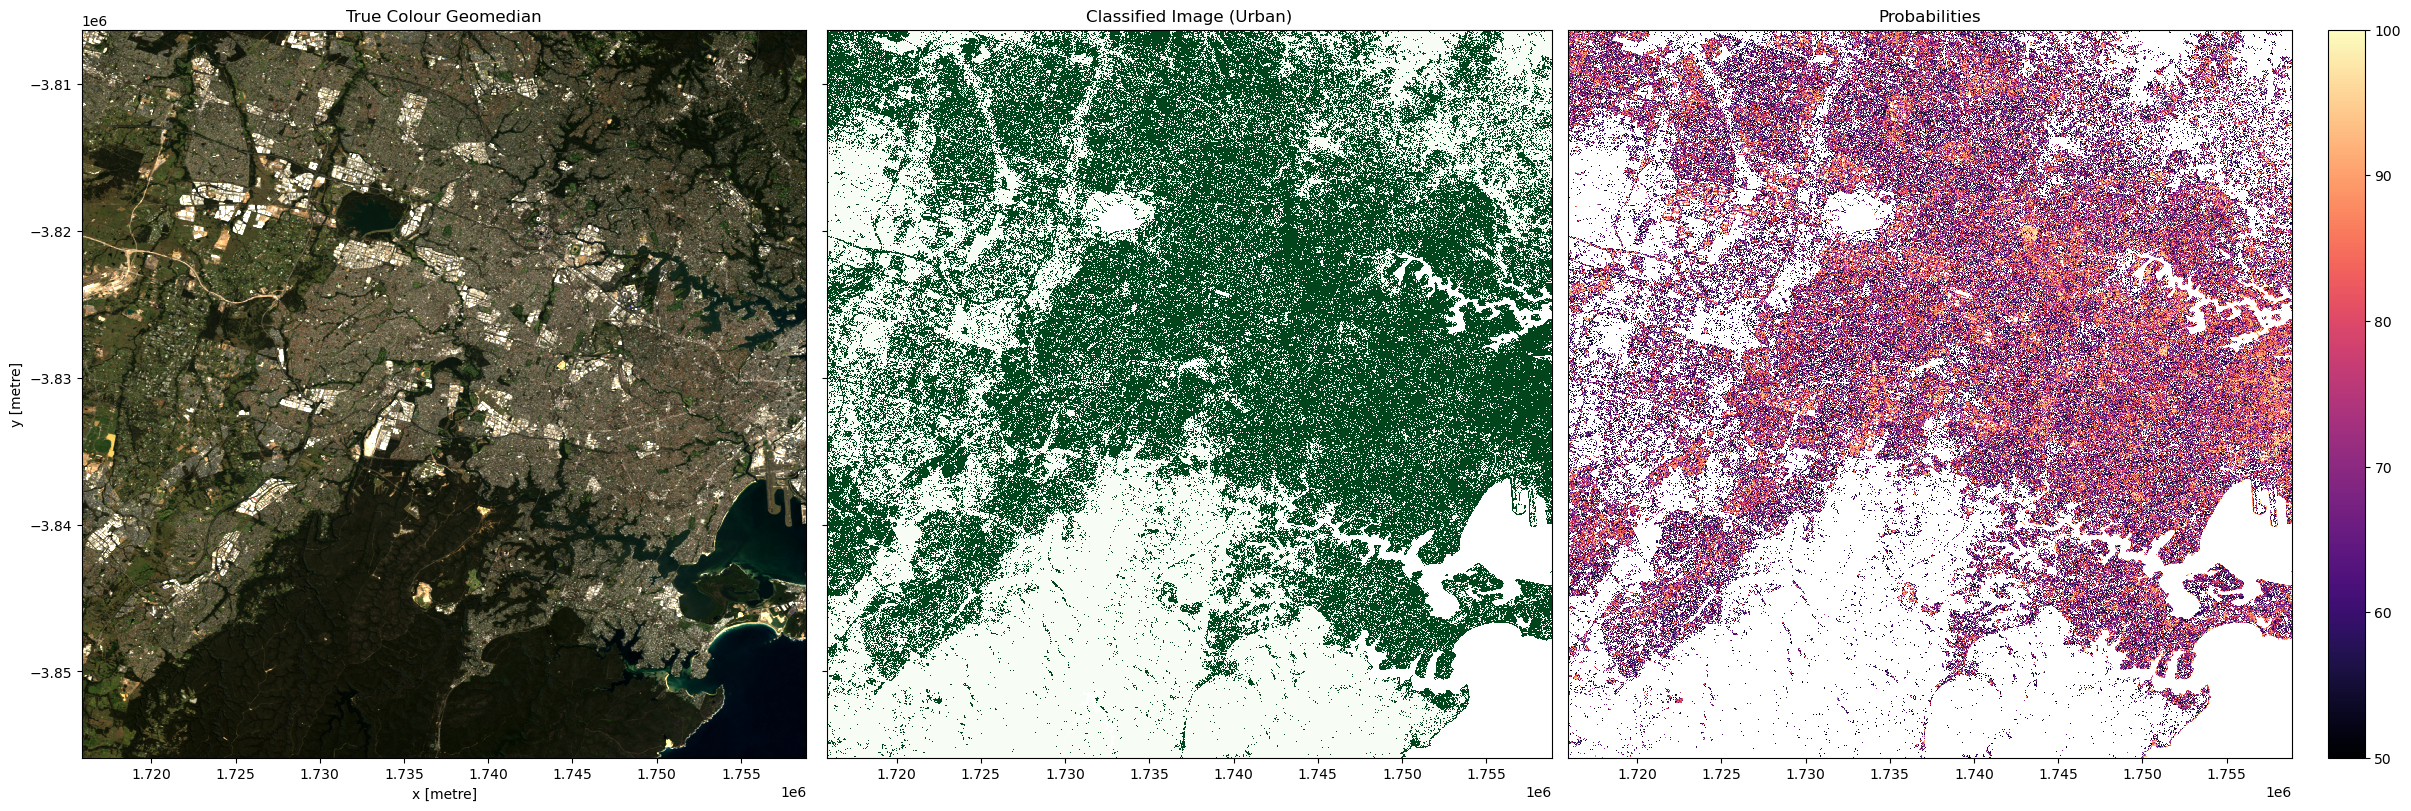

In [121]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharey=True, layout='constrained')

# Plot true colour image
rgb(predicted,
    ax=axes[0],
    percentile_stretch=(0.01, 0.99))

# data['VV_max'].plot(cmap="Greys_r", robust=True, ax=axes[0], add_colorbar=False)
# plt.title("Average VV");

# Plot classified image
predicted.Predictions.where(data['NDVI']>0).plot(ax=axes[1],
                                cmap='Greens',
                                add_labels=False,
                                add_colorbar=False)

predicted.Probabilities.where(predicted.Predictions == 1).where(data['NDVI']>0).plot(
     ax=axes[2],
     cmap='magma',
     vmin=50,
     vmax=100,
     add_labels=False,
     add_colorbar=True
)

# Remove axis on right plot
axes[2].get_yaxis().set_visible(False)

# Add plot titles
axes[0].set_title('True Colour Geomedian')
axes[1].set_title('Classified Image (Urban)')
axes[2].set_title('Probabilities');

In [124]:
ndvi = data['NDVI'].compute()
probs = predicted.Probabilities.where(predicted.Predictions == 1)
# (probs > 55).plot.imshow()

In [125]:
(probs > 50).where(ndvi>0).odc.explore(
    tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
            attr = 'Esri',
            name = 'Esri Satellite',
)

## Tags
<!-- Browse all available tags on the DEA User Guide's [Tags Index](https://knowledge.dea.ga.gov.au/genindex/) -->